In [1]:
! pip uninstall -q -y kaggle
! pip install -q kaggle --upgrade
! kaggle -v
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json /root/.kaggle/
# ! cp /content/drive/MyDrive/'Colab Notebooks'/kaggle.json ~/.kaggle/ 
! chmod 600 ~/.kaggle/kaggle.json 
! kaggle competitions download -q petfinder-pawpularity-score
! ls

     |████████████████████████████████| 58 kB 3.0 MB/s 
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
mkdir: cannot create directory ‘/root/.kaggle’: File exists
kaggle.json  petfinder-pawpularity-score.zip  sample_data  split.zip  timm.zip


In [2]:
# ! mkdir ./timmaster
! unzip -q timm.zip -d ./timm23

In [3]:
! mkdir ../input
! unzip -q petfinder-pawpularity-score.zip -d ../input/petfinder-pawpularity-score

In [4]:
! mkdir ./split
! unzip -q ./split.zip -d ./split

In [6]:
!wget https://dl.fbaipublicfiles.com/convnext/convnext_xlarge_22k_224.pth

--2022-01-13 04:54:32--  https://dl.fbaipublicfiles.com/convnext/convnext_xlarge_22k_224.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1571711303 (1.5G) [binary/octet-stream]
Saving to: ‘convnext_xlarge_22k_224.pth’

convnext_xlarge_22k 100%[===================>]   1.46G  26.7MB/s    in 57s     

2022-01-13 04:55:30 (26.4 MB/s) - ‘convnext_xlarge_22k_224.pth’ saved [1571711303/1571711303]



In [8]:
! git clone https://github.com/facebookresearch/ConvNeXt.git

Cloning into 'ConvNeXt'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 120 (delta 55), reused 114 (delta 49), pack-reused 0
Receiving objects: 100% (120/120), 45.45 KiB | 2.07 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [9]:
import sys

sys.path.append('./timm23/pytorch-image-models-master')
from timm import create_model
import pandas as pd
import numpy as np

In [10]:
sys.path.append('ConvNeXt')
import models.convnext

In [11]:
import fastai
fastai.__version__

'2.5.3'

In [12]:
import torch
torch.__version__

'1.10.0+cu111'

In [13]:
from fastai.vision.all import *

In [14]:
set_seed(701, reproducible=True)
BATCH_SIZE = 8                       #was 32

In [15]:
dataset_path = Path('../input/petfinder-pawpularity-score/')
dataset_path.ls()

(#5) [Path('../input/petfinder-pawpularity-score/test'),Path('../input/petfinder-pawpularity-score/test.csv'),Path('../input/petfinder-pawpularity-score/train.csv'),Path('../input/petfinder-pawpularity-score/train'),Path('../input/petfinder-pawpularity-score/sample_submission.csv')]

In [16]:
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [17]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,1,1,1,0,0,0,0,0,0,0,0,30,../input/petfinder-pawpularity-score/train/79ad50002156d86a1b5b9d814470ced7.jpg
1,0,0,1,1,0,0,0,0,1,1,0,1,39,../input/petfinder-pawpularity-score/train/fb84f1effbeee94cd8f9479bf4927c82.jpg
2,0,1,1,1,0,0,0,1,0,1,0,0,55,../input/petfinder-pawpularity-score/train/145320a9a1c876a2d27b9667ffb15fa8.jpg
3,0,0,1,1,0,0,0,0,0,0,0,0,69,../input/petfinder-pawpularity-score/train/6ba00c1158aa975ac8c0149bca9891a8.jpg
4,0,1,1,1,0,0,0,0,0,0,0,0,35,../input/petfinder-pawpularity-score/train/13f772ef658e539c60b360e323f3ea6e.jpg


In [20]:
import os

In [21]:
!ls ../root/.cache/torch/hub/checkpoints

ls: cannot access '../root/.cache/torch/hub/checkpoints': No such file or directory


In [23]:
seed=701
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [28]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [29]:
def get_data(fold):
    train_df_f = pd.read_csv(f'./split/skf_split_train_5cv_fold{fold}.csv')
    train_df_f['is_valid'] = False
    valid_df_f = pd.read_csv(f'./split/skf_split_val_5cv_fold{fold}.csv')
    valid_df_f['is_valid'] = True
    
    train_df_f = train_df_f.append(valid_df_f)
    train_df_f['Id'] = train_df_f['img_path'].apply(lambda x: x.split('.')[-2].split('/')[-1])
    train_df_f['img_path'] = train_df_f['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
    
    dls = ImageDataLoaders.from_df(
                                   train_df_f, #pass in train DataFrame
                                   valid_col='is_valid', #
                                   seed=999, #seed
                                   fn_col='img_path', #filename/path is in the second column of the DataFrame
                                   label_col='Pawpularity', #label is in the first column of the DataFrame
                                   y_block=RegressionBlock, #The type of target
                                   bs=BATCH_SIZE, #pass in batch size
                                   num_workers=8,
                                   item_tfms=Resize(224), #pass in item_tfms
                                   batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])
    ) #pass in batch_tfms
    return dls


In [31]:
#Valid Kfolder size
the_data = get_data(0)
assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

In [32]:
!pip install tensorboardX

     |████████████████████████████████| 124 kB 5.1 MB/s 


In [33]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('../input/convnext/ConvNeXt')
import timm
import models.convnext
import models.convnext_isotropic
import utils
import torch
from torch import nn

class ImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class=1, in_channels=3,pretrained_path=''):
        super().__init__()
        self.model = timm.create_model(model_arch,in_chans=in_channels, pretrained=False)
        self.model=self.load_pretrain(self.model,pretrained_path)
        num_ftrs = self.model.head.in_features
        self.model.head = nn.Linear(num_ftrs, n_class)
    def load_pretrain(self,model,pretrained_path):
        checkpoint = torch.load(pretrained_path, map_location='cpu')
        print("Load ckpt from %s" % pretrained_path)
        checkpoint_model = checkpoint['model']
        state_dict = model.state_dict()
        for k in ['head.weight', 'head.bias']:
            if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
                print(f"Removing key {k} from pretrained checkpoint")
                del checkpoint_model[k]
        utils.load_state_dict(model, checkpoint_model, prefix='')
        return model
    def forward(self, x):
        x = self.model(x)
        x=x.flatten()
        return x

# !wget https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_384.pth


In [34]:
def get_learner(fold_num):
    data = get_data(fold_num)

    model=ImgClassifier(model_arch='convnext_xlarge', pretrained_path='convnext_xlarge_22k_224.pth')
    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(func=petfinder_rmse)).to_fp16()
    
    return learn

In [35]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [36]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

In [38]:
assert torch.cuda.is_available()

Load ckpt from convnext_xlarge_22k_224.pth
Removing key head.weight from pretrained checkpoint
Removing key head.bias from pretrained checkpoint
Weights of ConvNeXt not initialized from pretrained model: ['head.weight', 'head.bias']


SuggestedLRs(valley=3.751863187062554e-05)

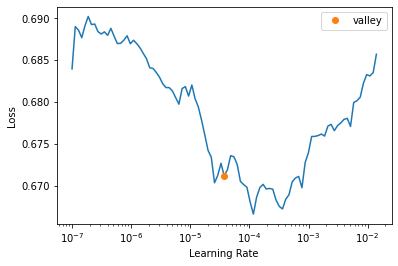

In [ ]:
get_learner(fold_num=0).lr_find(end_lr=3e-2)             #was-2

In [39]:
import gc

In [ ]:
all_preds = []

for i in range(5):

    print(f'Fold {i} results')
    
    learn = get_learner(fold_num=i)

    learn.fit_one_cycle(5, 3.751863187062554e-05, cbs=[SaveModelCallback('petfinder_rmse', comp=np.less), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
    
    learn.recorder.plot_loss()

    learn = learn.to_fp32()
    
    learn.export(f'model_fold_{i}.pkl')
    #learn.save(f'model_fold_{i}.pkl')
    
    dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    
    test_dl = dls.test_dl(test_df)
    
    preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
    
    all_preds.append(preds)
    
    learn.export(f'model_fold_{i}_aftertest.pkl')
    
    del learn

    torch.cuda.empty_cache()

    gc.collect()

Fold 0 results
Load ckpt from convnext_xlarge_22k_224.pth
Removing key head.weight from pretrained checkpoint
Removing key head.bias from pretrained checkpoint
Weights of ConvNeXt not initialized from pretrained model: ['head.weight', 'head.bias']


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.642824,0.645442,18.304035,1:29:14
1,0.635309,0.639801,17.571630,1:28:50


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 18.304035186767578.
Better model found at epoch 1 with petfinder_rmse value: 17.571630477905273.


In [ ]:
!ls ..

In [ ]:
all_preds

In [ ]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
preds = np.mean(np.stack(all_preds), axis=0)
sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)

In [ ]:
pd.read_csv('submission.csv').head()